### 라이브러리 로드

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### 데이터 로드

In [5]:
data = pd.read_csv('data/smartphones.csv', index_col=False)

### 데이터 전처리

In [6]:
def prepare_data(data):
    # 필요한 특성 선택
    hardware_features = ['processor_speed', 'battery_capacity', 'internal_memory',
                        'screen_size', 'refresh_rate', 'num_rear_cameras']

    # 결측치 처리
    numeric_data = data[hardware_features + ['price', 'avg_rating']].copy()
    numeric_data = numeric_data.fillna(numeric_data.mean())

    # 가격 대비 성능비 계산
    normalized_specs = numeric_data[hardware_features].apply(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    performance_score = normalized_specs.mean(axis=1)
    price_performance_ratio = performance_score / (numeric_data['price'] / numeric_data['price'].mean())

    # 데이터셋 준비
    X_hardware = numeric_data[hardware_features]
    X_ppr = pd.DataFrame({'price_performance_ratio': price_performance_ratio})
    y = numeric_data['avg_rating']

    return X_hardware, X_ppr, y

### 랜덤포레스트 학습

In [7]:
def train_random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    if isinstance(X, pd.DataFrame):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
    else:
        feature_importance = None

    return {
        'r2': r2,
        'rmse': rmse,
        'feature_importance': feature_importance,
        'test_actual': y_test,
        'test_pred': y_pred
    }

### 신경망 학습

In [8]:
def train_neural_network(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 데이터 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 모델 구성
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])

    # 모델 컴파일
    model.compile(optimizer='adam', loss='mse')

    # 모델 훈련
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        verbose=0
    )

    # 성능 평가
    y_pred = model.predict(X_test_scaled).flatten()
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {
        'r2': r2,
        'rmse': rmse,
        'test_actual': y_test,
        'test_pred': y_pred,
        'history': history.history
    }

### 랜덤 포레스트 분석 결과

In [9]:
# 데이터 준비
X_hardware, X_ppr, y = prepare_data(data)

# 랜덤 포레스트 분석
print("\n=== Random Forest Results ===")
rf_hardware_results = train_random_forest(X_hardware, y)
rf_ppr_results = train_random_forest(X_ppr, y)

print("\nHardware Specs Model:")
print(f"R² Score: {rf_hardware_results['r2']:.4f}")
print(f"RMSE: {rf_hardware_results['rmse']:.4f}")
print("\nFeature Importance:")
print(rf_hardware_results['feature_importance'])

print("\nPrice-Performance Ratio Model:")
print(f"R² Score: {rf_ppr_results['r2']:.4f}")
print(f"RMSE: {rf_ppr_results['rmse']:.4f}")


=== Random Forest Results ===

Hardware Specs Model:
R² Score: 0.5878
RMSE: 0.4255

Feature Importance:
            feature  importance
2   internal_memory    0.495749
0   processor_speed    0.185257
3       screen_size    0.104806
5  num_rear_cameras    0.093062
1  battery_capacity    0.064077
4      refresh_rate    0.057050

Price-Performance Ratio Model:
R² Score: 0.0186
RMSE: 0.6566


### 신경망 분석 결과

In [10]:
# 신경망 분석
print("\n=== Neural Network Results ===")
nn_hardware_results = train_neural_network(X_hardware, y)
nn_ppr_results = train_neural_network(X_ppr, y)

print("\nHardware Specs Model:")
print(f"R² Score: {nn_hardware_results['r2']:.4f}")
print(f"RMSE: {nn_hardware_results['rmse']:.4f}")

print("\nPrice-Performance Ratio Model:")
print(f"R² Score: {nn_ppr_results['r2']:.4f}")
print(f"RMSE: {nn_ppr_results['rmse']:.4f}")

# 결과 시각화
plt.figure(figsize=(15, 10))


=== Neural Network Results ===


c:\Users\tmddn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


c:\Users\tmddn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Hardware Specs Model:
R² Score: 0.4108
RMSE: 0.5087

Price-Performance Ratio Model:
R² Score: 0.2480
RMSE: 0.5748


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

### 랜덤 포레스트, 신경망 분석 결과 시각화

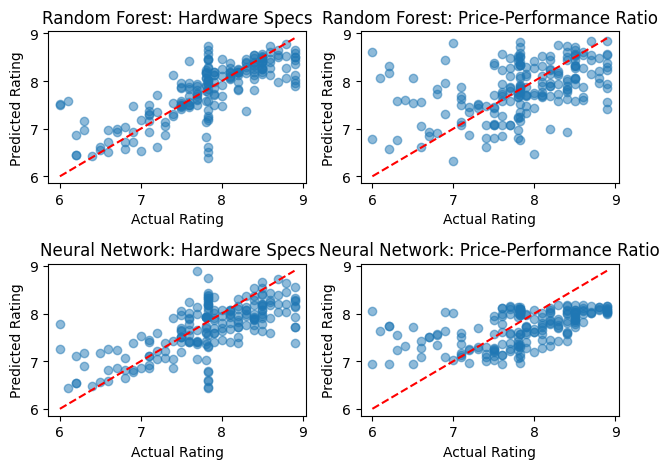

In [11]:
# 랜덤 포레스트 결과 시각화
plt.subplot(2, 2, 1)
plt.scatter(rf_hardware_results['test_actual'], rf_hardware_results['test_pred'], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Random Forest: Hardware Specs')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.subplot(2, 2, 2)
plt.scatter(rf_ppr_results['test_actual'], rf_ppr_results['test_pred'], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Random Forest: Price-Performance Ratio')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

# 신경망 결과 시각화
plt.subplot(2, 2, 3)
plt.scatter(nn_hardware_results['test_actual'], nn_hardware_results['test_pred'], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Neural Network: Hardware Specs')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.subplot(2, 2, 4)
plt.scatter(nn_ppr_results['test_actual'], nn_ppr_results['test_pred'], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Neural Network: Price-Performance Ratio')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.tight_layout()
plt.show()

### 상관관계 분석

In [16]:
def analyze_correlations_by_segments(data):
    """구간별 상관관계 분석"""
    # 결측치 처리
    numeric_data = data.copy()
    numeric_columns = ['processor_speed', 'battery_capacity', 'internal_memory',
                      'screen_size', 'refresh_rate', 'num_rear_cameras', 'price', 'avg_rating']
    numeric_data = numeric_data[numeric_columns].fillna(numeric_data[numeric_columns].mean())

    # 가격 구간 생성 (4분위)
    numeric_data['price_segment'] = pd.qcut(numeric_data['price'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

    # 하드웨어 스펙 종합 점수 계산
    hw_features = ['processor_speed', 'battery_capacity', 'internal_memory',
                  'screen_size', 'refresh_rate', 'num_rear_cameras']

    # 각 특성 정규화
    scaler = StandardScaler()
    normalized_hw = pd.DataFrame(
        scaler.fit_transform(numeric_data[hw_features]),
        columns=hw_features
    )

    # 종합 하드웨어 점수 계산
    numeric_data['hw_score'] = normalized_hw.mean(axis=1)

    # 전체 상관계수 계산
    overall_price_corr = stats.pearsonr(numeric_data['price'], numeric_data['avg_rating'])[0]
    overall_hw_corr = stats.pearsonr(numeric_data['hw_score'], numeric_data['avg_rating'])[0]

    # 구간별 상관계수 계산
    segment_correlations = {}
    for segment in numeric_data['price_segment'].unique():
        segment_data = numeric_data[numeric_data['price_segment'] == segment]
        price_corr = stats.pearsonr(segment_data['price'], segment_data['avg_rating'])[0]
        hw_corr = stats.pearsonr(segment_data['hw_score'], segment_data['avg_rating'])[0]
        segment_correlations[segment] = {
            'price_correlation': price_corr,
            'hw_correlation': hw_corr,
            'avg_price': segment_data['price'].mean(),
            'count': len(segment_data)
        }

    # 개별 하드웨어 스펙 상관계수
    hw_correlations = {}
    for feature in hw_features:
        hw_correlations[feature] = stats.pearsonr(numeric_data[feature], numeric_data['avg_rating'])[0]

    return {
        'overall_price_corr': overall_price_corr,
        'overall_hw_corr': overall_hw_corr,
        'segment_correlations': segment_correlations,
        'hw_correlations': hw_correlations,
        'data': numeric_data
    }

### 상관관계 분석 시각화

In [17]:
def visualize_results(results):
    """결과 시각화"""
    data = results['data']

    fig = plt.figure(figsize=(20, 12))

    # 1. 전체 상관관계 시각화
    plt.subplot(2, 2, 1)
    correlations = {
        'Price': results['overall_price_corr'],
        **results['hw_correlations']
    }
    plt.bar(correlations.keys(), correlations.values())
    plt.title('Overall Correlation with Rating')
    plt.xticks(rotation=45)
    plt.ylabel('Correlation Coefficient')

    # 2. 가격 구간별 상관계수 비교
    plt.subplot(2, 2, 2)
    segments = list(results['segment_correlations'].keys())
    price_corrs = [results['segment_correlations'][s]['price_correlation'] for s in segments]
    hw_corrs = [results['segment_correlations'][s]['hw_correlation'] for s in segments]

    x = np.arange(len(segments))
    width = 0.35

    plt.bar(x - width/2, price_corrs, width, label='Price Correlation')
    plt.bar(x + width/2, hw_corrs, width, label='Hardware Correlation')
    plt.title('Correlation by Price Segment')
    plt.xticks(x, segments, rotation=45)
    plt.ylabel('Correlation Coefficient')
    plt.legend()

    # 3. 가격과 평점의 산점도
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=data, x='price', y='avg_rating', hue='price_segment', alpha=0.6)
    plt.title('Price vs Rating')
    plt.xlabel('Price')
    plt.ylabel('Rating')

    # 4. 하드웨어 점수와 평점의 산점도
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=data, x='hw_score', y='avg_rating', hue='price_segment', alpha=0.6)
    plt.title('Hardware Score vs Rating')
    plt.xlabel('Hardware Score')
    plt.ylabel('Rating')

    plt.tight_layout()
    return fig

### 분석 실행, 시각화


=== Overall Correlations ===
Price vs Rating: 0.254
Hardware Score vs Rating: 0.573

=== Hardware Spec Correlations ===
processor_speed: 0.532
battery_capacity: -0.015
internal_memory: 0.405
screen_size: 0.194
refresh_rate: 0.571
num_rear_cameras: 0.454

=== Segment Analysis ===

Price Segment: High
Average Price: 77,428
Number of Products: 245
Price Correlation: -0.282
Hardware Correlation: 0.328

Price Segment: Medium-High
Average Price: 26,680
Number of Products: 245
Price Correlation: 0.232
Hardware Correlation: 0.497

Price Segment: Low
Average Price: 9,653
Number of Products: 249
Price Correlation: 0.207
Hardware Correlation: 0.075

Price Segment: Medium-Low
Average Price: 16,432
Number of Products: 241
Price Correlation: 0.456
Hardware Correlation: 0.433


C:\Users\tmddn\AppData\Local\Temp\ipykernel_5792\2719310164.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


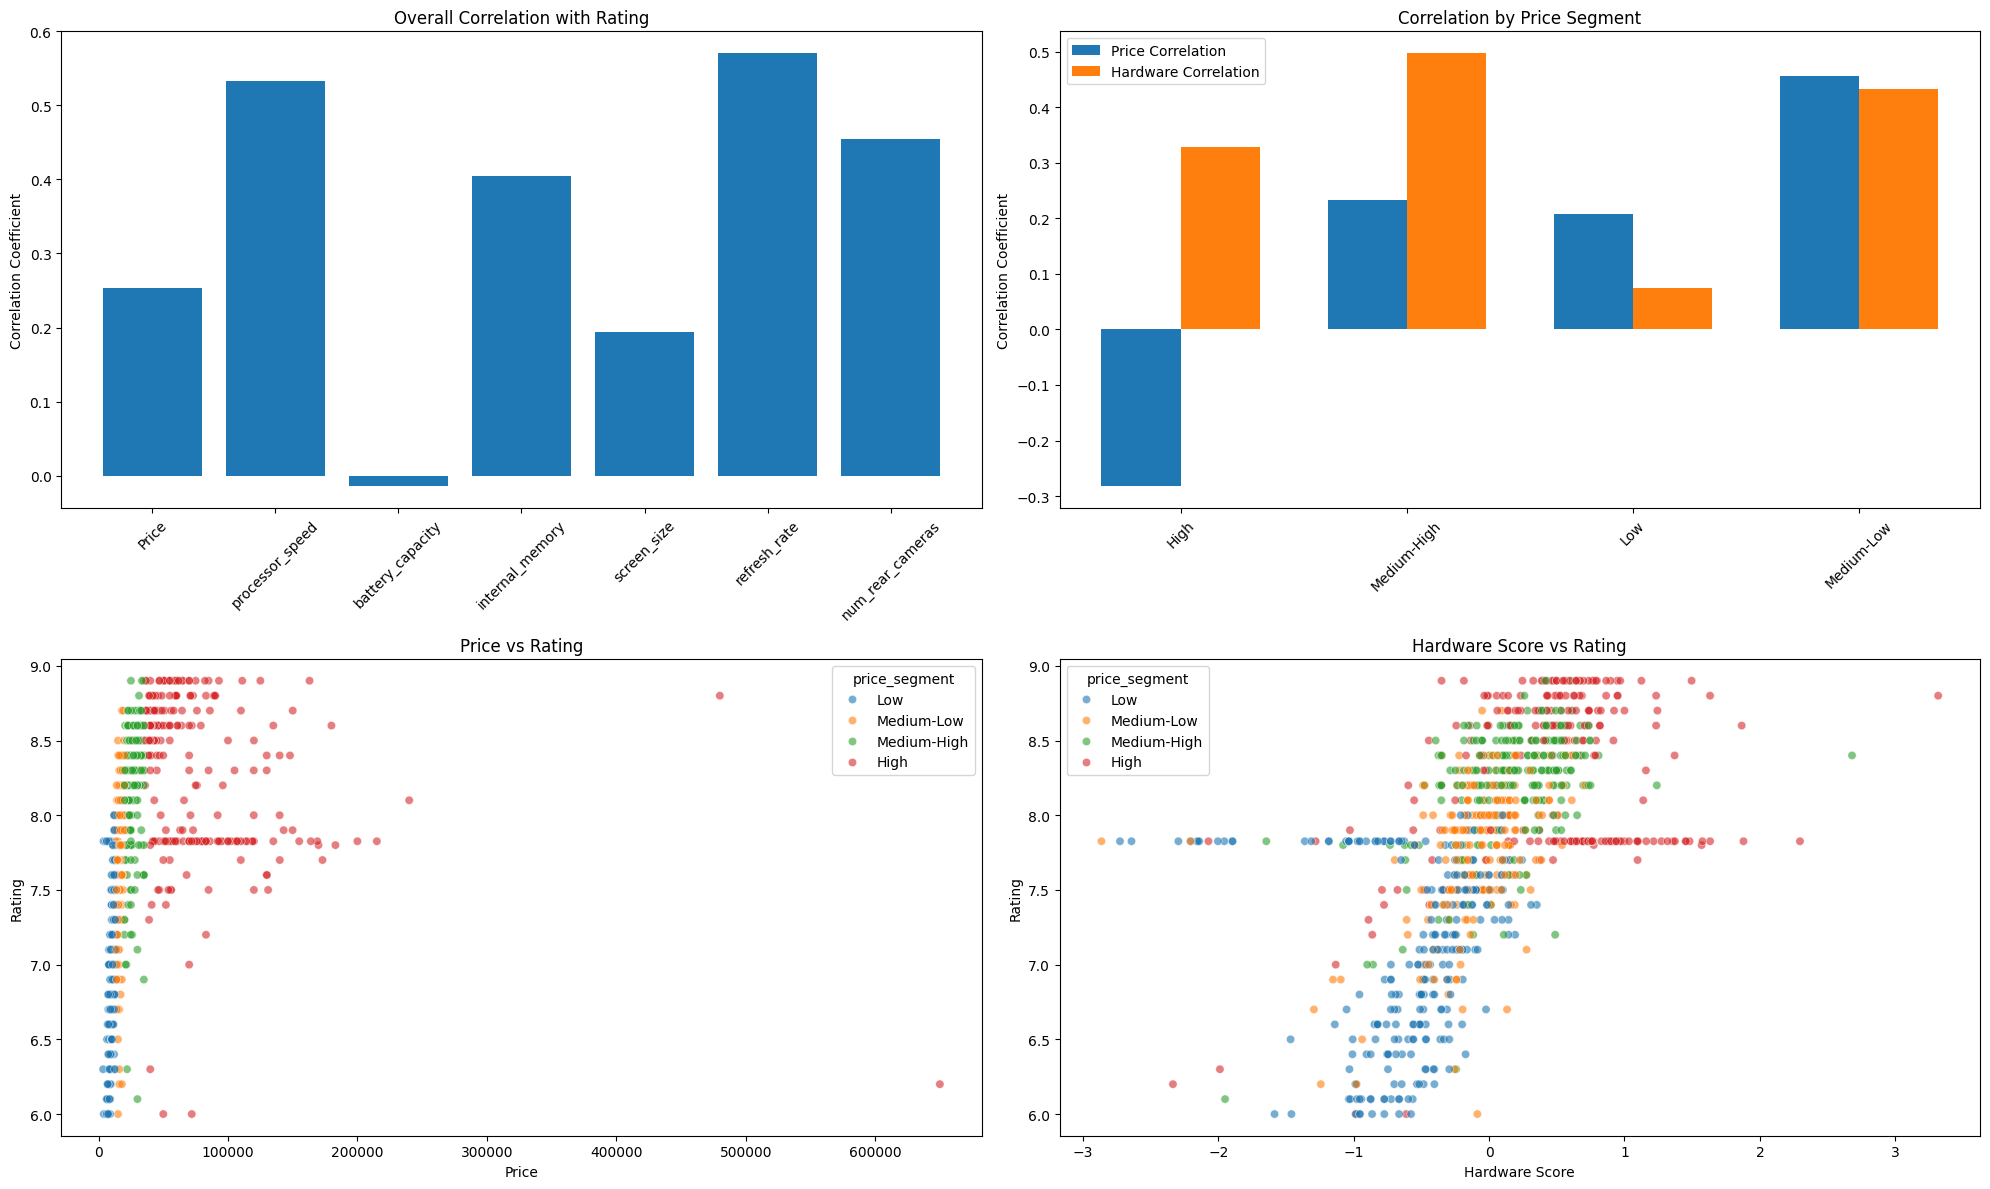

In [18]:
# 분석 실행
results = analyze_correlations_by_segments(data)

# 결과 출력
print("\n=== Overall Correlations ===")
print(f"Price vs Rating: {results['overall_price_corr']:.3f}")
print(f"Hardware Score vs Rating: {results['overall_hw_corr']:.3f}")

print("\n=== Hardware Spec Correlations ===")
for spec, corr in results['hw_correlations'].items():
    print(f"{spec}: {corr:.3f}")

print("\n=== Segment Analysis ===")
for segment, stats in results['segment_correlations'].items():
    print(f"\nPrice Segment: {segment}")
    print(f"Average Price: {stats['avg_price']:,.0f}")
    print(f"Number of Products: {stats['count']}")
    print(f"Price Correlation: {stats['price_correlation']:.3f}")
    print(f"Hardware Correlation: {stats['hw_correlation']:.3f}")

# 시각화
plt = visualize_results(results)
plt.show()

### 머신러닝 모델 통한 중요도 분석

In [19]:
# 머신러닝 모델을 통한 중요도 분석
X = results['data'][['price', 'hw_score']]
y = results['data']['avg_rating']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

print("\n=== Feature Importance from Random Forest ===")
importance_df = pd.DataFrame({
    'Feature': ['Price', 'Hardware Score'],
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df)


=== Feature Importance from Random Forest ===
          Feature  Importance
0           Price    0.597889
1  Hardware Score    0.402111
